# Forecasting Euribor with ARIMA

In this notebook Euribor rates are predicted with ARIMA model using statsmodels library. 

## Loading the data

In [36]:
import pandas as pd
import numpy as np
# load dataset
df = pd.read_csv('historical_euribor.csv', header=0, index_col=0)
# we don't need this column and just makes things harder
df = df.drop(['period'], axis=1)
# set date as index and convert the field to datetime
df.set_index('date', inplace=True)
df.index = pd.to_datetime(df.index)
#df.index = df.index.to_period('M')
print(df)

            1mo euribor  3mo euribor  6mo euribor  12mo euribor
date                                                           
1994-01-01       7.1200       6.9100       6.6700        6.3400
1994-02-01       6.9900       6.8600       6.6800        6.4200
1994-03-01       6.8400       6.7500       6.6500        6.5500
1994-04-01       6.6900       6.5700       6.5100        6.4600
1994-05-01       6.3200       6.2400       6.2100        6.2500
...                 ...          ...          ...           ...
2023-05-01       3.1474       3.3664       3.6790        3.8618
2023-06-01       3.3425       3.5359       3.8253        4.0073
2023-07-01       3.4690       3.6718       3.9425        4.1490
2023-08-01       3.6270       3.7803       3.9445        4.0730
2023-09-01       3.7577       3.8800       4.0303        4.1492

[357 rows x 4 columns]


## Parameter selection
ARIMA has three parameters (p,d,q):
-  p = is the order of the model
-  d = the degree of differentiation
-  q = order of the moving-average model.

Let's do some statistical testing and plotting to esimate good parameters for our model.

### Trends and patterns
From plots below we can see quite obvious downward and seasonal trends so our data is not stationary and Augmented Dickey-Fuller (ADF) test confirms this. Euribor rates follow each other quite closely but shorter rates peak a little later than longer euribors. This suggest we should use differentiation. Plotting the differentiated data of 1st order and performing ADF again confirms that first order of differentation is sufficient to make the data stationary. Thus d=1 is sufficient. 

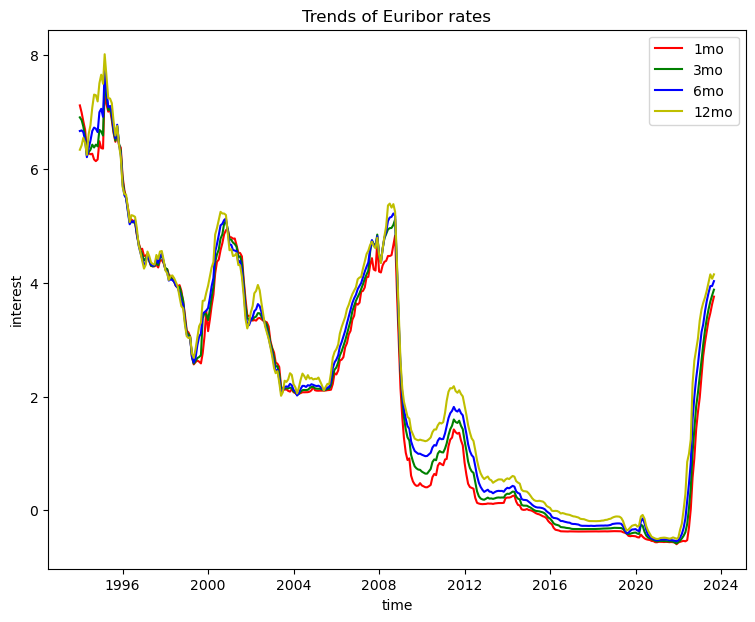

In [37]:
from matplotlib import pyplot as plt
# let's study our data for trends and patterns first
plt.plot(df['1mo euribor'], color='r', label='1mo') 
plt.plot(df['3mo euribor'], color='g', label='3mo') 
plt.plot(df['6mo euribor'], color='b', label='6mo') 
plt.plot(df['12mo euribor'], color='y', label='12mo') 

# Naming the x-axis, y-axis and the whole graph 
plt.xlabel("time") 
plt.ylabel("interest") 
plt.title("Trends of Euribor rates") 
  
# Adding legend, which helps us recognize the curve according to it's color 
plt.legend() 
  
# To load the display window 
plt.show() 

ADF test for undifferentiated data gives p-value of 0,189877 which is not significant at 95% confidence level and thus indicates that data is non-stationary. 

In [38]:
# Augmented Dickey-Fuller test cofirms our data is not stationary
# It's sufficient to study single euribor since the rates follows each other so closely. 

from statsmodels.tsa.stattools import adfuller

result = adfuller(df['3mo euribor'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.246287
p-value: 0.189877
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571


After first order differentation the p-value is 0,000753 indicating significance so the data is now stationary. Plotting the original and differentiated data confirms this. Thus q = 1.

ADF Statistic: -4.165761
p-value: 0.000753
Critical Values:
	1%: -3.450
	5%: -2.870
	10%: -2.571


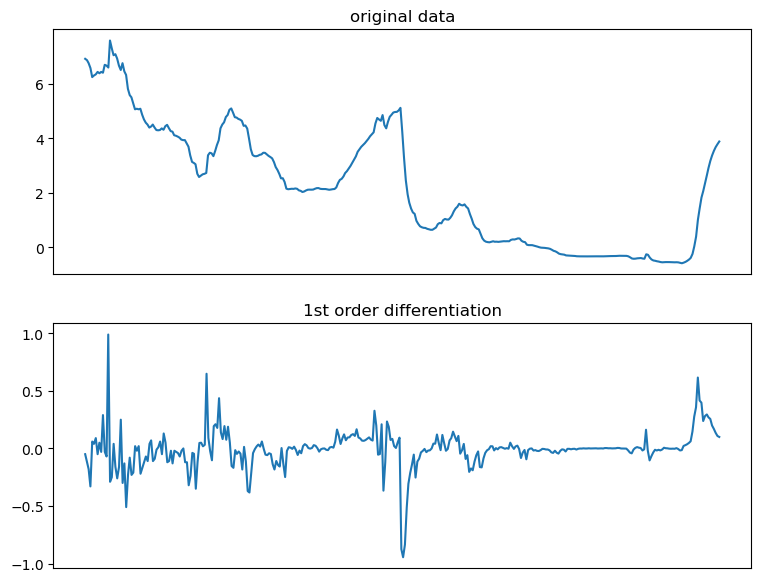

In [39]:
# Next try to find at which order of differentation we can make the data stationary

df['diff_3mo'] = df['3mo euribor'].diff()
#df.dropna(inplace=True)

result = adfuller(df['diff_3mo'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

# First order is enough (p-value is now significant)

plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':100})
 
# Original Series
fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(df['3mo euribor']); 
ax1.set_title('original data')
ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(df['3mo euribor'].diff())
ax2.set_title('1st order differentiation')
ax2.axes.xaxis.set_visible(False)

plt.show()


### Autocorrelation 

Autocorrelation plot suggests strong autocorrelation since the plot is out of the 5% significance limits for most of the lags. Looking more closely partial auto-correlation plots we see that the first two lags are significantly above the limits so let's choose p=2. With same logic we can select q=2.

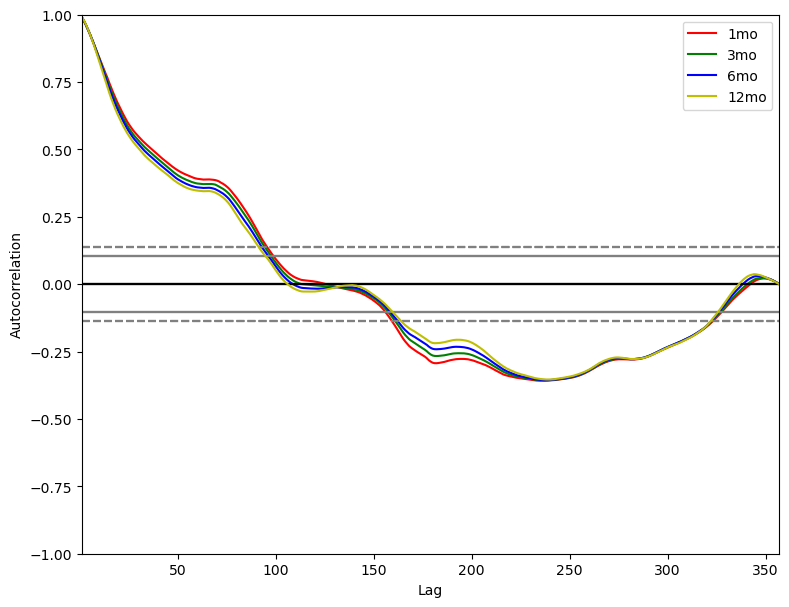

In [40]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df['1mo euribor'], color='r', label='1mo')
autocorrelation_plot(df['3mo euribor'], color='g', label='3mo')
autocorrelation_plot(df['6mo euribor'], color='b', label='6mo') 
autocorrelation_plot(df['12mo euribor'], color='y', label='12mo') 

plt.show()

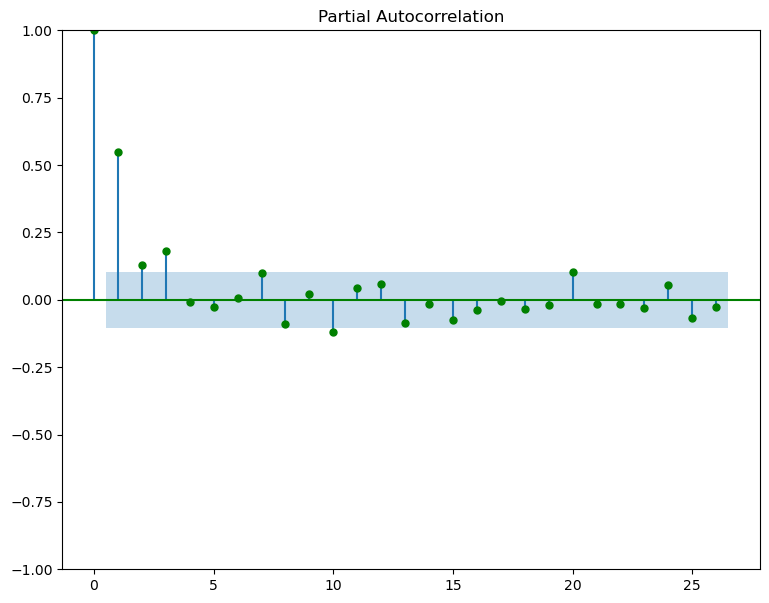

In [41]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df['diff_3mo'].dropna(), color='g')

plt.show()

q parameter can be found with the help of autocorrelaction function. Again the first two lags seems to be most significant so select q=2.

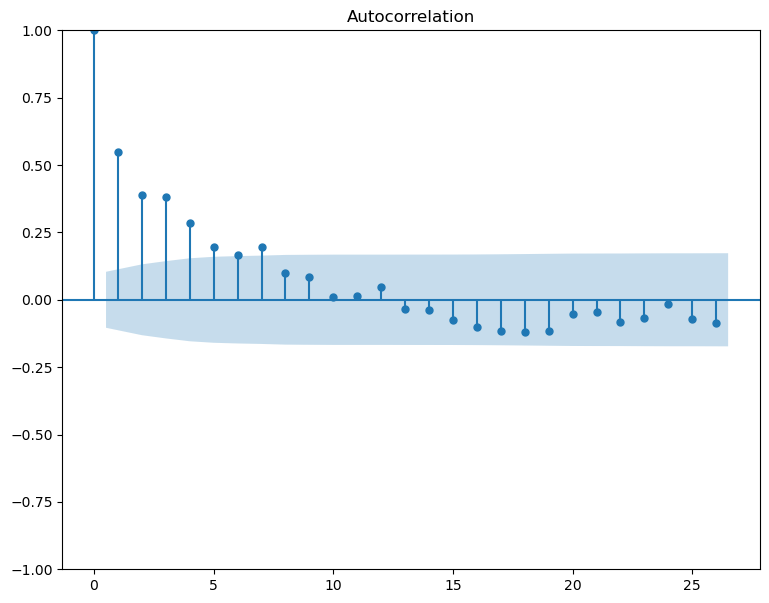

In [42]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df['diff_3mo'].dropna())
plt.show()


## Conclusions in parameter selection
By using plotting and statistical hypothesis testing we may conclude that ARIMA(2,1,2) should be a good fit for our model. 

# ARIMA fitting

Now that we have the model we can finally fit our data. 

In [43]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [46]:
# helper that does the actual ARIMA forecasting
def forecast(predictions, history, test_data):
    # predict next months rate
    for t in range(len(test_data)):
        model = ARIMA(history, order=(2,1,2))
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        obs = test_data[t]
        history.append(obs)
        #print('predicted=%f, expected=%f' % (yhat, obs))

def one_year_forecast(predictions, history):
    for i in range(1,13):
        model = ARIMA(history, order=(2,1,2))
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        history.append(yhat)
        predictions.append(yhat)
        print(yhat)

In [ ]:
# this column was just to make the previous data analysis easier
df = df.drop(['diff_3mo'], axis=1)

/home/tintti/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3.858706816921854
3.946237691038123
4.0198856360248385
4.08320236669172
4.136786574714173
4.182659335077597
4.221601930458507
4.254866277099532
4.283152151141472
4.307284433304828
4.327823917844494
4.345336770376778
1mo euribor
MSE: 0.004320455861920614
MAE: 0.027207448452382425
RMSE: 0.0657301746682649
Last observed values: [3.7577], last predicted values: [3.7443089529208518]
October prediction: 3.858706816921854
November prediction: 3.946237691038123
October 24 prediction: 4.345336770376778


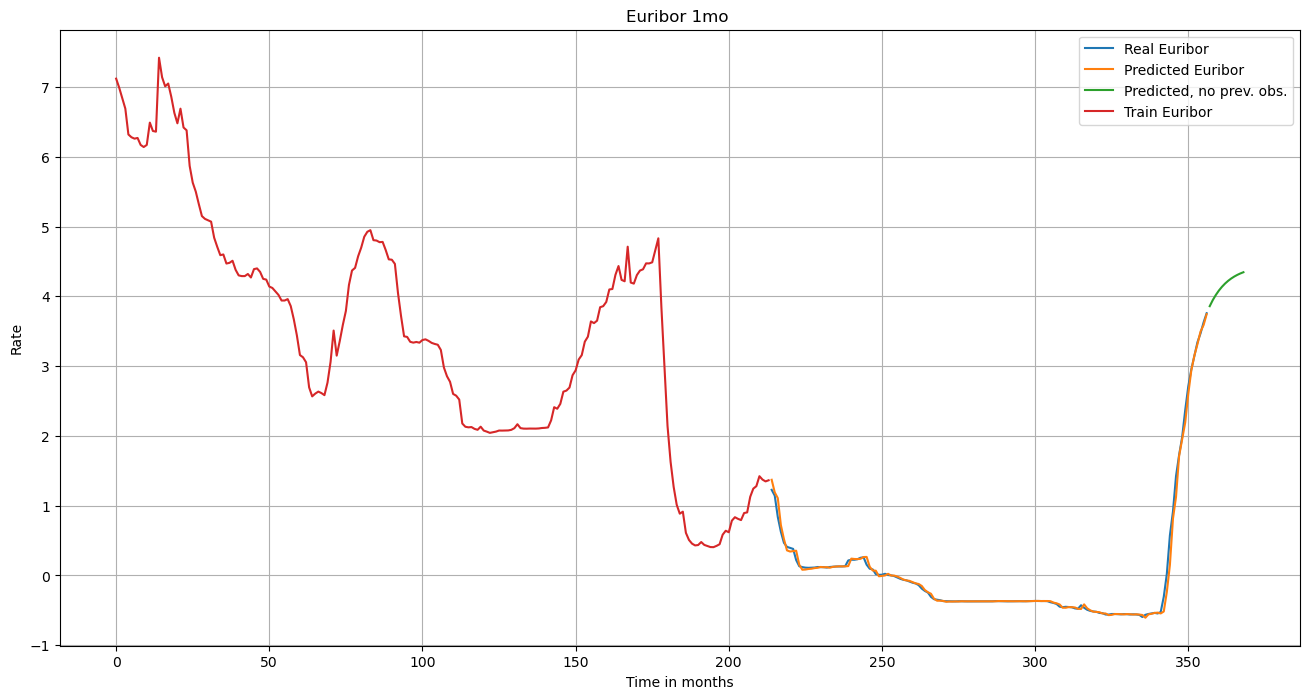

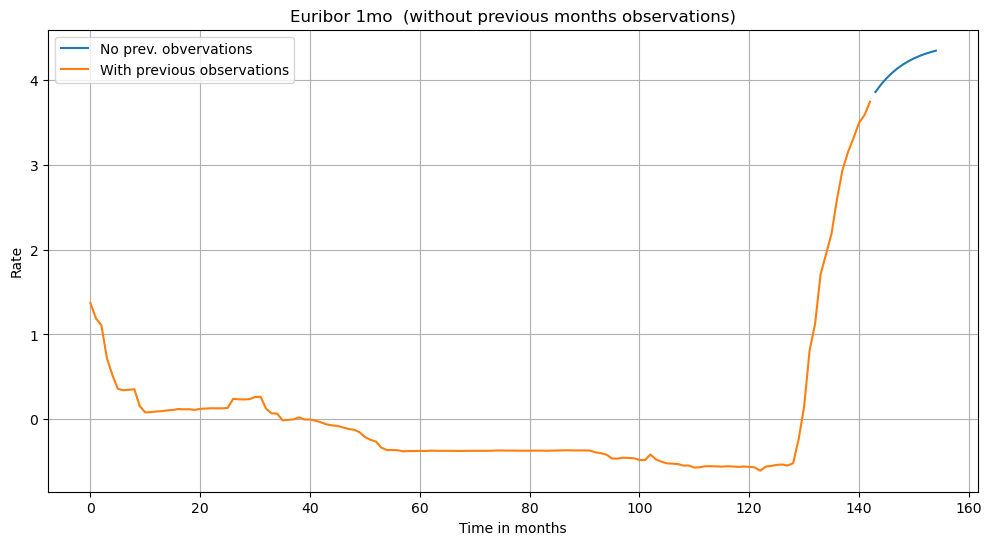

3.9621294015629434
4.0256556221068065
4.081242398098059
4.125111059052836
4.162850066001883
4.193059106734502
4.218741753399063
4.2395015247598495
4.257006077706607
4.271253956136453
4.283198858212967
4.292968134470935
3mo euribor
MSE: 0.003591052169156985
MAE: 0.027711154269218555
RMSE: 0.05992538835215826
Last observed values: [3.88], last predicted values: [3.8678122691168597]
October prediction: 3.9621294015629434
November prediction: 4.0256556221068065
October 24 prediction: 4.292968134470935


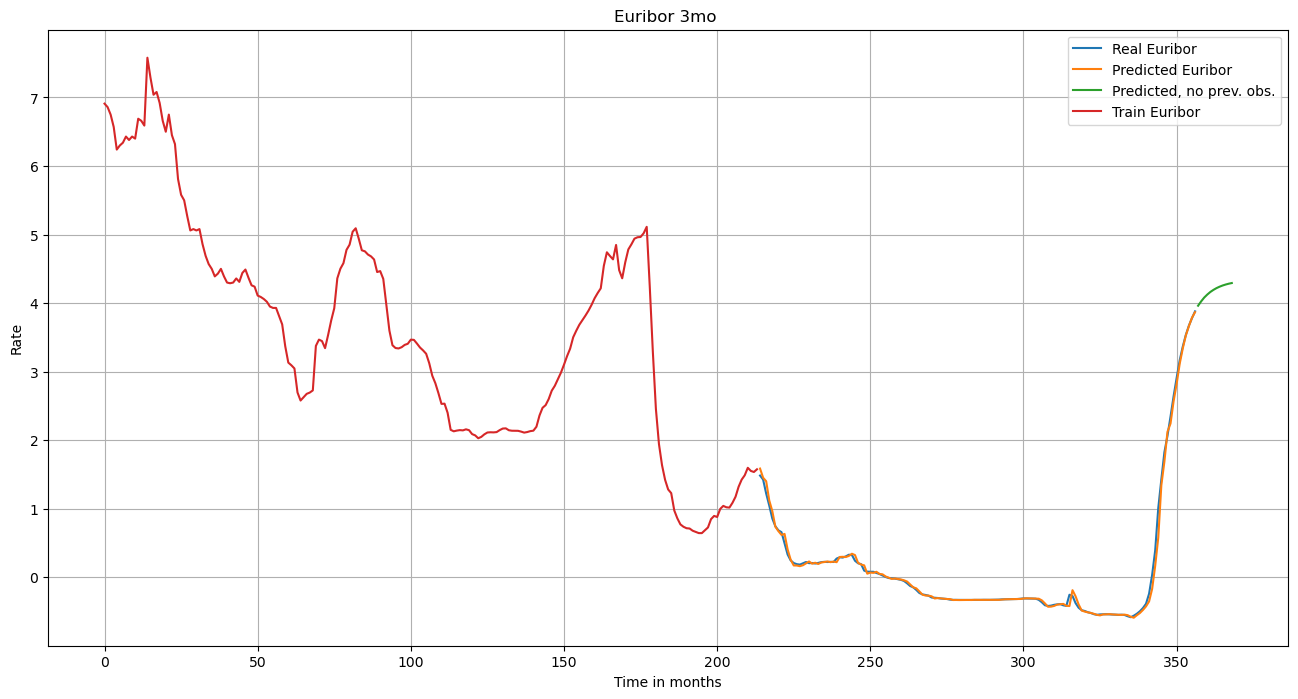

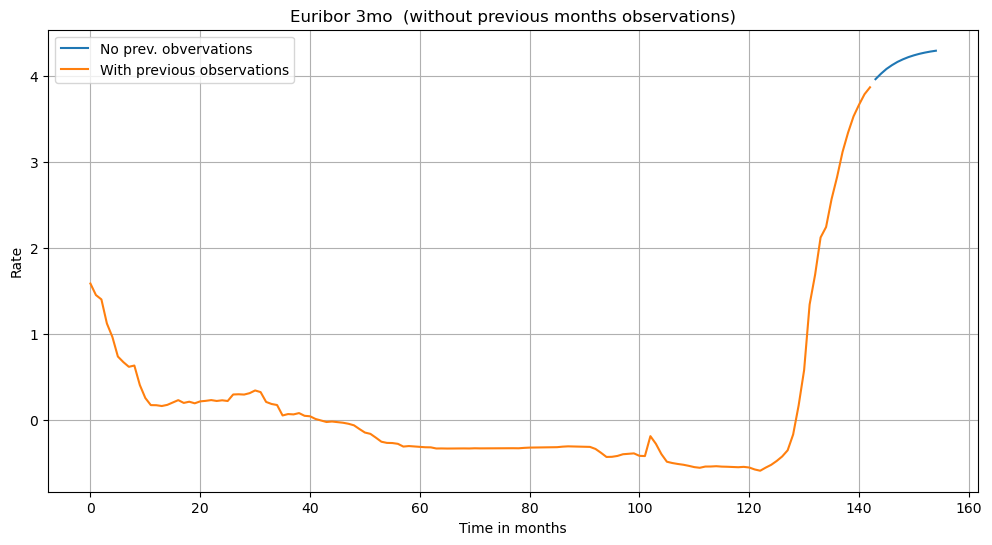

/home/tintti/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4.095328055509602
4.130983684758706
4.172504070373111
4.196864311035523
4.223491067502158
4.240008864966652
4.257150570955423
4.268284507524514
4.279356690215818
4.286826965947734
4.293999169477494
4.298992455338621
6mo euribor
MSE: 0.004348632353391201
MAE: 0.031204149912878964
RMSE: 0.06594416087411531
Last observed values: [4.0303], last predicted values: [3.972763866071923]
October prediction: 4.095328055509602
November prediction: 4.130983684758706
October 24 prediction: 4.298992455338621


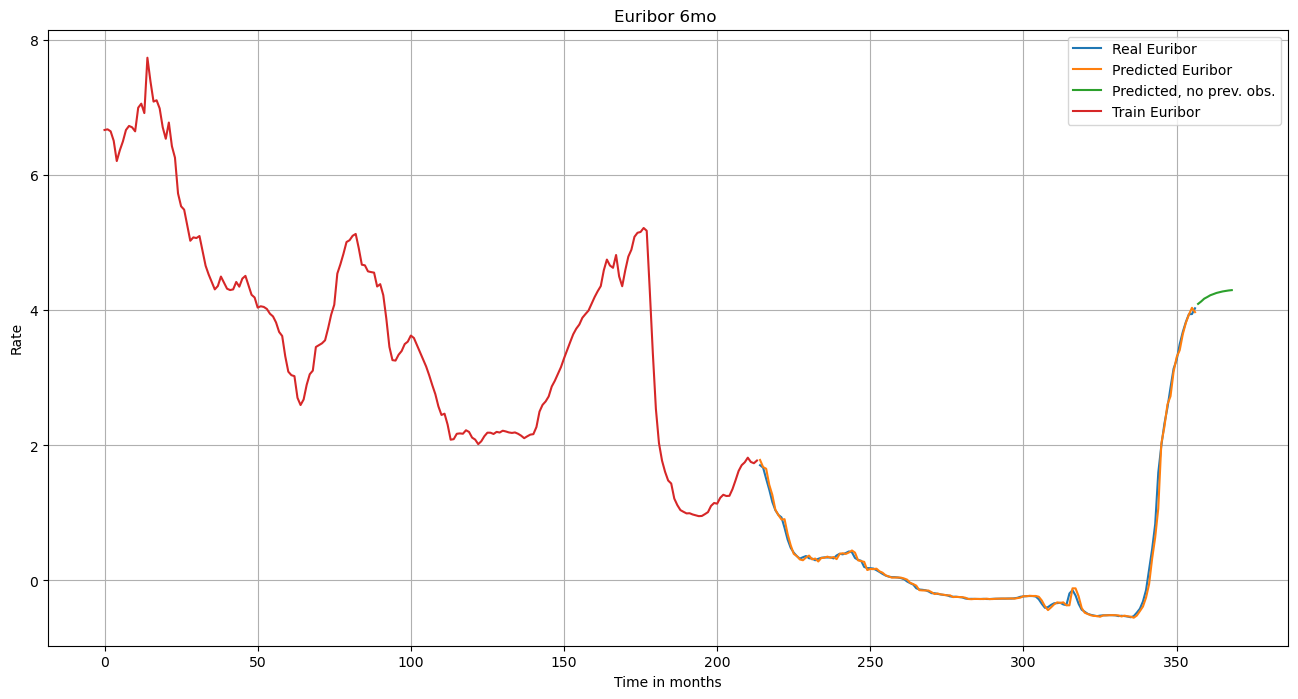

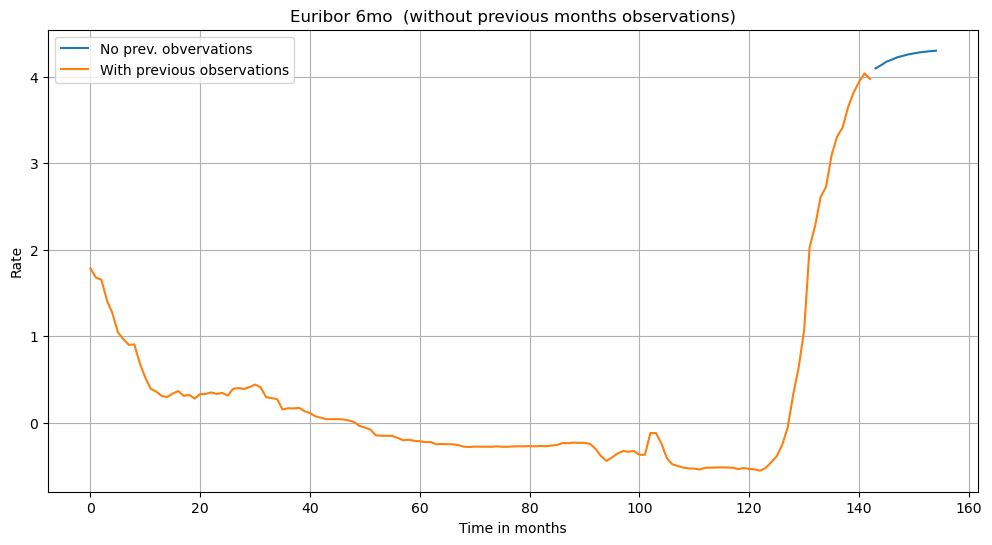

/home/tintti/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/tintti/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/tintti/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4.217708260369543
4.232600806361964
4.27191552476745
4.284357895394016
4.307344137442615
4.3166761498843105
4.330334845425453
4.336946311317069
4.345178384357661
4.349707248076135
4.354728569474389
4.35776376498524
12mo euribor
MSE: 0.008375783262875037
MAE: 0.040550007191684015
RMSE: 0.09151930541079864
Last observed values: [4.1492], last predicted values: [4.048672839331766]
October prediction: 4.217708260369543
November prediction: 4.232600806361964
October 24 prediction: 4.35776376498524


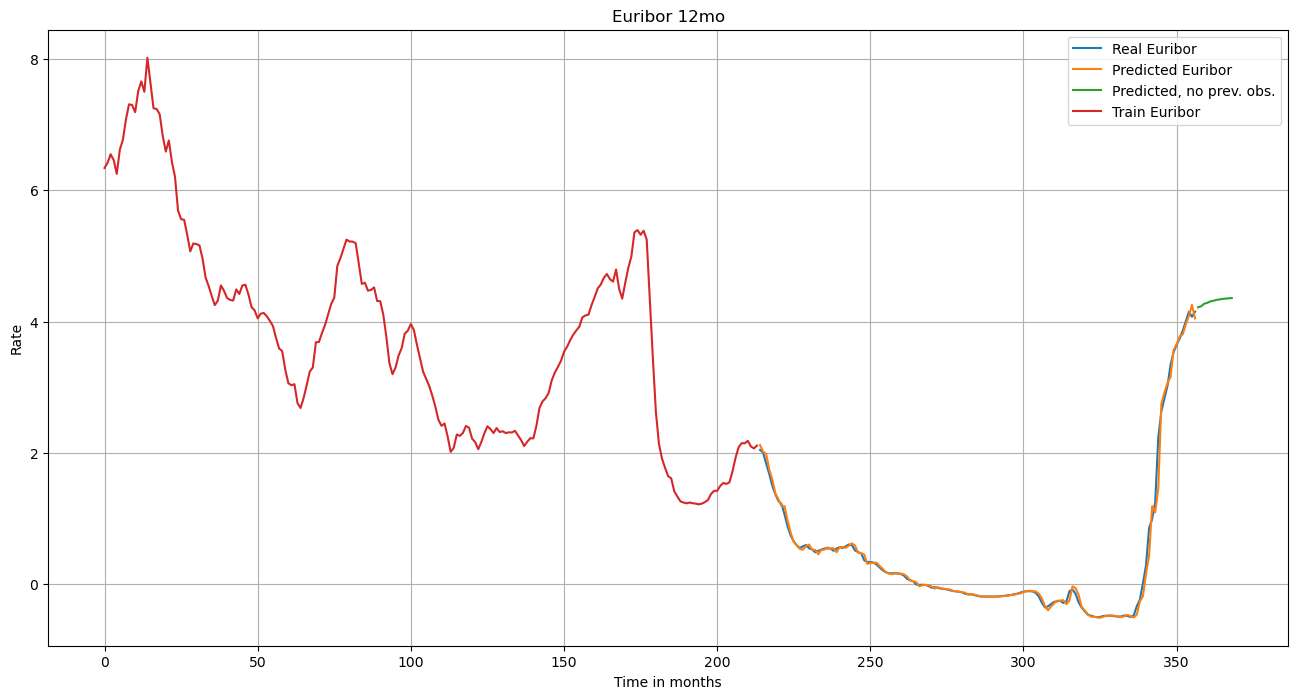

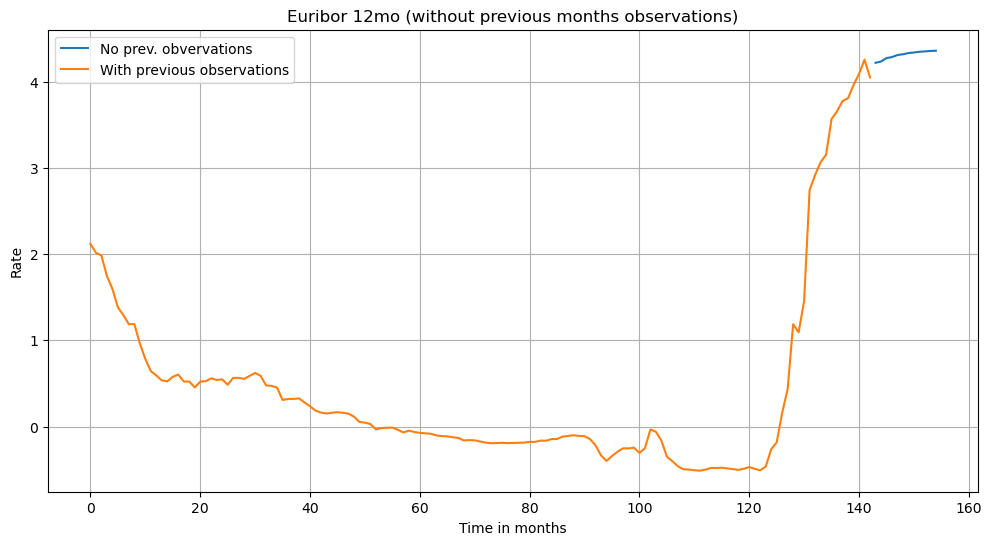

In [59]:
# fit the model

# loop through 1/3/6/12 mo interest rates in data frame 
for (colName, colData) in df.items():
    X = colData.values
    # split into train and test sets
    size = int(len(X) * 0.6)
    train, test = X[0:size], X[size:len(X)]
    history = [x for x in train]
    predictions = []

    # rolling forecast
    forecast(predictions, history, test)

    # forecasting the unknown (12 month forecast)
    pred_1yr = []
    one_year_forecast(pred_1yr, history)

    print(colName)
    # evaluate performance
    mse = mean_squared_error(test, predictions)
    print(f"MSE: {mse}")
    mae = mean_absolute_error(test, predictions)
    print(f"MAE: {mae}")
    rmse = math.sqrt(mean_squared_error(test, predictions))
    print(f"RMSE: {rmse}")
    print(f"Last observed values: {test[-1:]}, last predicted values: {predictions[-1:]}")
    print(f"October prediction: {pred_1yr[0]}")
    print(f"November prediction: {pred_1yr[1]}")
    print(f"October 24 prediction: {pred_1yr[11]}")

    # plot forecasts against actual outcomes
    plt.figure(figsize=(16,8))
    plt.plot(np.arange(len(predictions)) + len(train), test)
    plt.plot(np.arange(len(predictions)) + len(train), predictions)
    plt.plot(np.arange(len(pred_1yr)) + len(predictions) + len(train), pred_1yr)
    plt.plot(train)


    plt.legend(['Real Euribor', 'Predicted Euribor', 'Predicted, no prev. obs.', 'Train Euribor'])
    plt.title(f"Euribor {colName[:4]}")
    plt.xlabel('Time in months')
    plt.ylabel('Rate')
    plt.grid(True)
    plt.savefig(f"arima_model_{colName[:4]}.png")
    plt.show()

    # closeup about the predictions
    new_preds = predictions + pred_1yr
    plt.figure(figsize=(12,6))
    plt.plot(np.arange(len(pred_1yr))+len(predictions), pred_1yr)
    plt.plot(predictions)


    plt.legend(['No prev. obvervations', 'With previous observations'])
    plt.title(f"Euribor {colName[:4]} (without previous months observations)")
    plt.xlabel('Time in months')
    plt.ylabel('Rate')
    plt.grid(True)
    plt.savefig(f"arima_model_pred_{colName[:4]}.png")
    plt.show()

